In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import uuid

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"/COGNITION"
dreamspath=datapath+"/DREAMS"
masspath=datapath+"/MASS"


## define a fixed samplerate

In [2]:
samplerate=200

## load mass

In [3]:
#annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate,onlySpindlesFilteredN2=True)
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [4]:
annotations=annotations[annotations.type=='spindle'].reset_index(drop=True)
len(annotations)

33458

In [5]:
minDuration=0.3
maxDuration=5
annotations=annotations[annotations.duration>minDuration].reset_index(drop=True)
annotations=annotations[annotations.duration<maxDuration].reset_index(drop=True)
len(annotations)

33269

In [6]:
annotations.head()

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
0,spindle,E1,0001,0001,888.327805,0.640579,200,888.968384,177666,177794
1,spindle,E1,0001,0001,905.758061,0.578094,200,906.336155,181152,181267
2,spindle,E1,0001,0001,917.731574,0.847603,200,918.579177,183546,183716
3,spindle,E1,0001,0001,922.078189,0.878845,200,922.957034,184416,184591
4,spindle,E1,0001,0001,939.055445,0.757767,200,939.813212,187811,187963


In [7]:
signalsMetadata

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS
5,0006,MASS_0006.pkl,C3-CLE,28990.0,200,False,MASS
6,0007,MASS_0007.pkl,C3-CLE,28302.0,200,False,MASS
7,0008,MASS_0008.pkl,C3-CLE,26846.0,200,False,MASS
8,0009,MASS_0009.pkl,C3-CLE,29834.0,200,False,MASS
9,0010,MASS_0010.pkl,C3-CLE,25930.0,200,False,MASS


In [8]:
signals,_,_= loadMASSSpindles(masspath,returnSignals=True)

In [9]:
print(256*25/32)   #<- TBD: make this automatic
# WARNING: parameters hardcoded ----------------------->
myUp=25
myDown=32
#<------------------------------------------------------

200.0


In [10]:
#1. resample
for ind, row in signalsMetadata.iterrows():
    signals[row.subjectId]=sg.resample_poly(signals[row.subjectId],up=myUp,down=myDown)

#2. update metadata
signalsMetadata["samplerate"]=samplerate
signalsMetadata["duration"]=signalsMetadata.apply(
    lambda row: len(signals[row.subjectId])/row.samplerate,
    axis=1) #it should be the exact same duration

#3. update annotations
annotations['samplerate']=samplerate
annotations['startInd']=annotations.apply(
    lambda row: seconds2index(row.startTime,row.samplerate),
    axis=1)
annotations['stopInd']=annotations.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate),
    axis=1)

## Preprocess

broadband in 0-40Hz, previous experiments (up tp 50Hz, are now in folders as .../features_old/...)

In [11]:
def preprocessVector(vector,samplerate):
    #1. Lowpass 40Hz
    vector=filterBand(vector,[0,40],samplerate,filterOrder=4)
    #2. Z-score
    m=np.mean(vector)
    s=np.std(vector)
    vector=(vector-m)/s
    return vector

In [12]:
for subject,signal in signals.items():
    signals[subject]=preprocessVector(signal,samplerate)

prepare extended dataframe of all possible training examples

In [13]:
signalsMetadata['excerptDimension']=signalsMetadata.apply(lambda row: int(row.duration*row.samplerate),axis=1)

In [14]:
allExtended=pd.DataFrame()

In [15]:
for ind,row in signalsMetadata.iterrows():
    thisExtended=pd.DataFrame({
        'trainIndex':np.arange(row.excerptDimension),
        'subjectId':row.subjectId
    })
    allExtended=pd.concat([allExtended,thisExtended])

In [16]:
allExtended

,trainIndex,subjectId
0,0,0001
1,1,0001
2,2,0001
3,3,0001
4,4,0001
...,...,...
5278395,5278395,0019
5278396,5278396,0019
5278397,5278397,0019
5278398,5278398,0019


prepare annotations to use

In [17]:
usedAnnotations=annotations[annotations.labelerId=='0001'].reset_index(drop=True)

prepare all possible labels for training

In [18]:
labels={}
for index, row in signalsMetadata.iterrows():
    labels[row.subjectId]=excerptAnnotationsToLabels(usedAnnotations[usedAnnotations.subjectId==row.subjectId],excerptDimension=row.excerptDimension)

In [19]:
#check
for index, row in signalsMetadata.iterrows():
    print(row.excerptDimension==len(labels[row.subjectId]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


prepare all possible slides for training

In [56]:
paddedSignals={}
for index, row in signalsMetadata.iterrows():
    paddedSignals[row.subjectId]=padVectorBothSides(signals[row.subjectId],window2half(601),method='closest')

In [57]:
slides={}
for index, row in signalsMetadata.iterrows():
    slides[row.subjectId]=np_tricks.sliding_window_view(paddedSignals[row.subjectId],(601,))

In [58]:
#check
for index, row in signalsMetadata.iterrows():
    print(row.excerptDimension==len(slides[row.subjectId]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


prepare the NN

In [22]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers


In [103]:
X_input = layers.Input((None,1))
X = layers.Conv1D(filters=200,kernel_size=(601),activation='relu')(X_input)
X = layers.Conv1D(filters=100,kernel_size=(1),activation='relu')(X)
X = layers.Conv1D(filters=50,kernel_size=(1),activation='relu')(X)
X = layers.Conv1D(filters=25,kernel_size=(1),activation='relu')(X)
X = layers.Conv1D(filters=5,kernel_size=(1),activation='relu')(X)
X = layers.Conv1D(filters=1,kernel_size=(1),activation='sigmoid')(X)
X = layers.Flatten()(X)
model = models.Model(inputs=X_input,outputs=X)

In [104]:
print(model.summary())

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, None, 1)]         0         
                                                                 
 conv1d_74 (Conv1D)          (None, None, 200)         120400    
                                                                 
 conv1d_75 (Conv1D)          (None, None, 100)         20100     
                                                                 
 conv1d_76 (Conv1D)          (None, None, 50)          5050      
                                                                 
 conv1d_77 (Conv1D)          (None, None, 25)          1275      
                                                                 
 conv1d_78 (Conv1D)          (None, None, 5)           130       
                                                                 
 conv1d_79 (Conv1D)          (None, None, 1)           6  

create a generator

In [105]:
allExtended.columns

Index(['trainIndex', 'subjectId'], dtype='object')

In [106]:
#   spin Generator       ------------------------------------------
class spinGen(tf.keras.utils.Sequence):
    def __init__(self, slides, labels, allExtended,
                batch_size=1024,
                shuffle=True):
        
        #copy variables
        self.slides = slides.copy()
        self.labels = labels.copy()
        self.allExtended = allExtended.copy()
        self.batch_size = batch_size
        self.shuffle = shuffle
        #compute df and n
        if shuffle:
            self.df=allExtended.sample(frac=1)
        else:
            self.df=allExtended
        self.n = len(self.df)

    def __getitem__(self, index):
        batch = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__get_data(batch)

    def __get_data(self,batch):
        #inputs
        index_batch = batch['trainIndex']
        subject_batch = batch['subjectId']
        inputs = np.asarray([self.__get_input(index,subject) for index,subject in zip(index_batch,subject_batch)])
        #outputs
        outputs= np.asarray([self.__get_label(index,subject) for index,subject in zip(index_batch,subject_batch)])
        return inputs, outputs

    def __get_input(self, index,subject):
        slide=self.slides[subject][index]
        slide=slide[...,np.newaxis]
        return slide
    
    def __get_label(self, index,subject):
        label=self.labels[subject][index]
        label=label[...,np.newaxis]
        return label

    def __len__(self):
        return self.n // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.df=self.df.sample(frac=1)

In [107]:
test=spinGen(slides,labels,allExtended)

In [108]:
a,b=next(iter(test))

In [109]:
a.shape

(1024, 601, 1)

In [110]:
b.shape

(1024, 1)

In [111]:
optimizer = optimizers.Adam()
loss_fn = tf.keras.losses.binary_crossentropy
model.compile(optimizer, loss_fn)

In [113]:
history = model.fit(spinGen(slides,labels,allExtended),epochs=1)

109987/109987 [==============================] - 845s 8ms/step - loss: 0.0261


In [114]:
history.history

{'loss': [0.026115866377949715]}

### training error

In [115]:
dumpPickle("modelDL_POC2.pkl",model)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv1d
......vars
.........0
.........1
...layers\conv1d_1
......vars
.........0
.........1
...layers\conv1d_2
......vars
.........0
.........1
...layers\conv1d_3
......vars
.........0
.........1
...layers\conv1d_4
......vars
.........0
.........1
...layers\conv1d_5
......vars
.........0
.........1
...layers\flatten
......vars
...layers\input_layer
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-09-01 13:18:04         5099
met

In [116]:
model=loadPickle("modelDL_POC2.pkl")

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-09-01 13:18:04         5099
metadata.json                                  2023-09-01 13:18:04           64
variables.h5                                   2023-09-01 13:18:04      1800912
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv1d
......vars
.........0
.........1
...layers\conv1d_1
......vars
.........0
.........1
...layers\conv1d_2
......vars
.........0
.........1
...layers\conv1d_3
......vars
.........0
.........1
...layers\conv1d_4
......vars
.........0
.........1
...layers\conv1d_5
......vars
.........0
.........1
...layers\flatten
......vars
...layers\input_layer
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........1

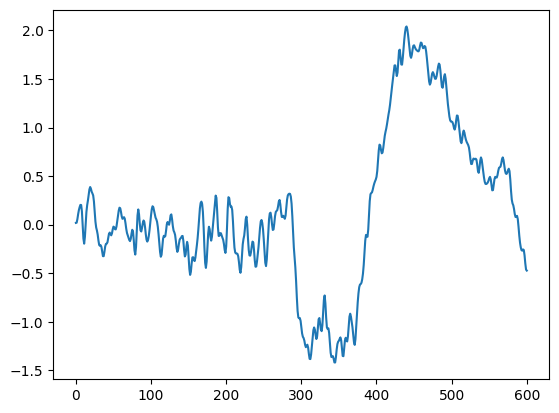

In [117]:
plt.plot(slides["0001"][50000])

In [28]:
subjectId='0001'

In [29]:
slides[subjectId][0:30].shape

(30, 601)

In [68]:
paddedSignals['0001'][:601,np.newaxis].shape

(601, 1)

In [118]:
aux=model.predict(paddedSignals['0001'][np.newaxis,...,np.newaxis],verbose=0)

In [120]:
aux.shape

(1, 5791200)

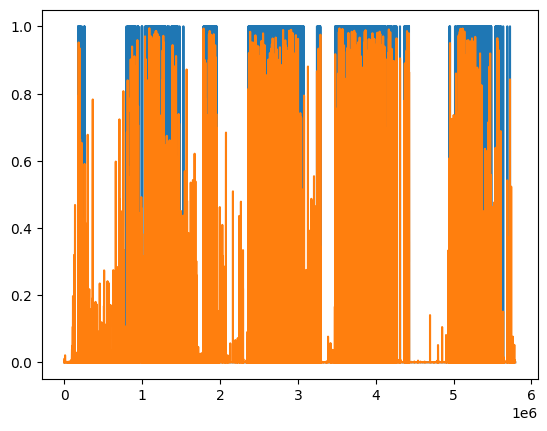

In [122]:
plt.plot(labels['0001'])
plt.plot(aux.flatten())


In [123]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

In [124]:
metrics=[]
precisions=[]
recalls=[]
for threshold in thresholds:
    rawLabels=aux>=threshold
    processedLabels=labelingProcess(rawLabels.flatten(),0.1,0.3,samplerate)
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    gtAnnotations=labelVectorToAnnotations(labels['0001'],samplerate) 
    f,r,p=annotationPairToMetrics(gtAnnotations,processedAnnotations)
    metrics.append(f)
    recalls.append(r)
    precisions.append(p)

In [125]:
metrics

[0.8057070919009651,
 0.814388489208633,
 0.8008452192287374,
 0.7380541162924582,
 0.6695544554455446,
 0.5824468085106383,
 0.516445066480056,
 0.389272030651341]

In [126]:
recalls

[0.9195402298850575,
 0.8132183908045977,
 0.7260536398467433,
 0.6139846743295019,
 0.5181992337164751,
 0.41954022988505746,
 0.35344827586206895,
 0.24329501915708812]

In [127]:
precisions

[0.7169529499626587,
 0.8155619596541787,
 0.8928150765606596,
 0.924963924963925,
 0.9458041958041958,
 0.9521739130434783,
 0.9584415584415584,
 0.9731800766283525]